In [56]:
# Initializing spark
import findspark
findspark.init("/u/cs451/packages/spark")

In [73]:
# Creating a spark session
from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("Project").master("local[3]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [248]:
# Importing the required libraries
from pyspark.sql.functions import udf, col, regexp_replace, month
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import NGram
from pyspark.sql.functions import explode
from pyspark.sql.types import StringType, ArrayType, FloatType
import pandas as pd


# Cleaning the tweets's text

In [59]:
# Reading the tweets csv file
tweets_raw = spark.read.csv('tweets.csv', header=True, inferSchema=True, multiLine=True, encoding="UTF-8", sep=',', quote='"',escape='"')

In [401]:
# Cleaning the text

# Using regexp to keep digits, letters, and certain symbols only
text_raw = tweets_raw.select('handle', 'text', (regexp_replace('text', "(&amp)+|(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t'])|(\w+:\/\/\S+)", "")).alias('text_clean'), 'is_retweet', 'original_author', month('time').alias('month') , 'lang', 'retweet_count', 'favorite_count')

# Tokenization
# Defining the initializer
tokenizer = Tokenizer(inputCol='text_clean', outputCol='words')
# Applying the tokenizer on the text
tokenized  = tokenizer.transform(text_raw)

# Removing the stop words
sw_remover = StopWordsRemover(inputCol='words', outputCol='words_no_sw')
sw_removed = sw_remover.transform(tokenized)

# Filter length word < 2
filter_length_udf = udf(lambda row: [x for x in row if len(x) > 2], ArrayType(StringType()))
clean_text = sw_removed.withColumn('words_clean', filter_length_udf(col('words_no_sw')))

# Stemming thet text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
clean_text = clean_text.withColumn('words_stem', stemmer_udf("words_clean"))

# Checking if the text is clean and keeping the english tweets only
clean_text = clean_text.filter("lang = 'en'").select('handle', 'text', 'words_clean', 'words_stem', 'is_retweet', 'original_author', 'month', 'retweet_count', 'favorite_count')

In [402]:
# The schema
clean_text

DataFrame[handle: string, text: string, words_clean: array<string>, words_stem: array<string>, is_retweet: boolean, original_author: string, month: int, retweet_count: int, favorite_count: int]

In [336]:
clean_text.show(10)

+---------------+--------------------+--------------------+--------------------+----------+---------------+-----+-------------+--------------+
|         handle|                text|         words_clean|          words_stem|is_retweet|original_author|month|retweet_count|favorite_count|
+---------------+--------------------+--------------------+--------------------+----------+---------------+-----+-------------+--------------+
| HillaryClinton|The question in t...|[question, electi...|[question, elect,...|     false|           null|    9|          218|           651|
| HillaryClinton|Last night, Donal...|[last, night, don...|[last, night, don...|      true|       timkaine|    9|         2445|          5308|
| HillaryClinton|Couldn't be more ...|[proud, vision, c...|[proud, vision, c...|      true|          POTUS|    9|         7834|         27234|
| HillaryClinton|If we stand toget...|[stand, together,...|[stand, togeth, n...|     false|           null|    9|          916|          2542|

# Data exploration

## Frequently used words by the candidates
Please note that only the tweets writen by the candidates will be taken into consideration for this part (i.e. retweets won't be considered)

### Frequently used words overall

In [337]:
# Finding the most used word for all candidates
word_counts_all = clean_text.filter('!is_retweet').withColumn('word', explode('words_clean')).groupBy('word').count().sort('count', ascending=False)


In [338]:
word_counts_all.show(10)

+---------+-----+
|     word|count|
+---------+-----+
|  hillary|  914|
|    trump|  869|
|    thank|  551|
|    great|  511|
|   donald|  400|
|   people|  387|
|  america|  366|
|     make|  332|
|president|  326|
|      new|  256|
+---------+-----+
only showing top 10 rows



### Frequently used words by Hillary Clinton

In [339]:
# The words mostly used by each candidate

# Hillary word counts
hillary_tweets = clean_text.filter("handle = 'HillaryClinton'").filter('!is_retweet')
word_counts_hillary = hillary_tweets.filter('!is_retweet').withColumn('word', explode('words_clean')).groupBy('word').count().sort('count', ascending=False)


In [340]:
word_counts_hillary.show(10)

+---------+-----+
|     word|count|
+---------+-----+
|  hillary|  580|
|    trump|  561|
|   donald|  347|
|president|  217|
|     make|  168|
|  america|  165|
|   people|  165|
|      one|  137|
|  trump's|  118|
|     need|  116|
+---------+-----+
only showing top 10 rows



### Frequently used words by Donald Trump

In [341]:
# Trump word counts
trump_tweets = clean_text.filter("handle = 'realDonaldTrump'").filter('!is_retweet')
word_counts_trump = trump_tweets.filter('!is_retweet').withColumn('word', explode('words_clean')).groupBy('word').count().sort('count', ascending=False)


In [342]:
word_counts_trump.show(10)

+-------+-----+
|   word|count|
+-------+-----+
|  thank|  510|
|  great|  457|
|hillary|  334|
|  trump|  308|
| people|  222|
|america|  201|
|    new|  186|
|   cruz|  183|
|crooked|  181|
|clinton|  179|
+-------+-----+
only showing top 10 rows



## Working on the retweets (i.e. tweets not writen by the candidates)

In [343]:
# Creating a dataframe containing columns relevent to this analysis
retweets = clean_text.filter('is_retweet').select('handle', 'text', 'words_clean', 'original_author', 'retweet_count', 'favorite_count')

In [344]:
retweets.show()

+---------------+--------------------+--------------------+---------------+-------------+--------------+
|         handle|                text|         words_clean|original_author|retweet_count|favorite_count|
+---------------+--------------------+--------------------+---------------+-------------+--------------+
| HillaryClinton|Last night, Donal...|[last, night, don...|       timkaine|         2445|          5308|
| HillaryClinton|Couldn't be more ...|[proud, vision, c...|          POTUS|         7834|         27234|
| HillaryClinton|3) Has Trump offe...|[trump, offered, ...|         mcuban|         1087|          2824|
| HillaryClinton|The election is j...|[election, weeks,...|       ddlovato|         3347|          7698|
|realDonaldTrump|On National #Vote...|[national, make, ...|            GOP|         2953|          6963|
| HillaryClinton|So. Everything yo...|[everything, feel...|   shondarhimes|         1328|          2435|
| HillaryClinton|Register and vote...|[register, vote, 

### Finding the authors they retweeted the most

#### Authors frequently retweeted by Hillary

In [345]:
# For Hillary
retweets_hillary_counts = retweets.filter("handle = 'HillaryClinton'").groupBy('original_author').count().sort('count', ascending=False)

retweets_hillary_counts.show(10)

+---------------+-----+
|original_author|count|
+---------------+-----+
|TheBriefing2016|   79|
|            HFA|   56|
|       timkaine|   41|
|       JoeBiden|   15|
|    johnpodesta|   12|
|    mayaharris_|   11|
|  BernieSanders|    9|
|  rosenbergerlm|    8|
| ChelseaClinton|    7|
|     Ann_OLeary|    7|
+---------------+-----+
only showing top 10 rows



#### Authors frequently retweeted by Trump

In [346]:
# For Trump
retweets_trump_counts = retweets.filter("handle = 'realDonaldTrump'").groupBy('original_author').count().sort('count', ascending=False)

retweets_trump_counts.show(10)

+---------------+-----+
|original_author|count|
+---------------+-----+
|      EricTrump|   17|
|     DanScavino|    8|
| DonaldJTrumpJr|    8|
|  DRUDGE_REPORT|    8|
|      TeamTrump|    6|
|     AnnCoulter|    5|
|    IvankaTrump|    4|
|         JoeNBC|    4|
|  CLewandowski_|    3|
|  RealBenCarson|    3|
+---------------+-----+
only showing top 10 rows



#### Visualizing the results
The user can choose the candidate

Enter 'h' for Hillary Clinton and 't' for Donald Trump: h


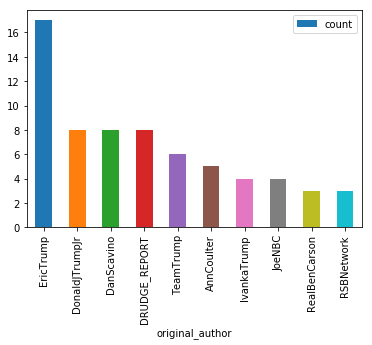

In [347]:
user_input = input("Enter 'h' for Hillary Clinton and 't' for Donald Trump: ")

if user_input == 'h':
    authors_plot = retweets_trump_counts.limit(10).toPandas()

elif user_input == 't':
    authors_plot = retweets_trump_counts.limit(10).toPandas()
    
authors_plot.plot('original_author', 'count', kind = 'bar')
plt.show()

### Finding the retweets with most likes

#### For Hillary

##### Favorite sum

In [362]:
# Hillary
retweets_hillary_likes_sum = retweets.filter("handle = 'HillaryClinton'").select('original_author', 'favorite_count').groupBy('original_author').sum('favorite_count').sort('sum(favorite_count)', ascending=False).limit(10)
retweets_hillary_likes_sum.show(10,False)


+---------------+-------------------+
|original_author|sum(favorite_count)|
+---------------+-------------------+
|POTUS          |402245             |
|timkaine       |291212             |
|TheBriefing2016|171011             |
|JoeBiden       |144088             |
|HFA            |140817             |
|BernieSanders  |131707             |
|billclinton    |128328             |
|elizabethforma |124283             |
|SenSanders     |113734             |
|repjohnlewis   |66014              |
+---------------+-------------------+



##### Favorite average

In [363]:
retweets_hillary_likes_avg = retweets.filter("handle = 'HillaryClinton'").select('original_author', 'favorite_count').groupBy('original_author').avg('favorite_count').sort('avg(favorite_count)', ascending=False).limit(10)
retweets_hillary_likes_avg.show(10,False)


+---------------+-------------------+
|original_author|avg(favorite_count)|
+---------------+-------------------+
|POTUS          |100561.25          |
|SenSanders     |56867.0            |
|TammyforIL     |46043.0            |
|funnyordie     |45833.0            |
|jtimberlake    |38132.0            |
|Lin_Manuel     |26644.0            |
|JohnKasich     |22933.5            |
|ElizabethBanks |22672.0            |
|billclinton    |21388.0            |
|elizabethforma |20713.833333333332 |
+---------------+-------------------+



#### For Trump

##### Favorites sum

In [364]:
# Trump
retweets_trump_likes_sum = retweets.filter("handle = 'realDonaldTrump'").select('original_author', 'favorite_count').groupBy('original_author').sum('favorite_count').sort('sum(favorite_count)', ascending=False).limit(10)
retweets_trump_likes_sum.show(10,False)

+---------------+-------------------+
|original_author|sum(favorite_count)|
+---------------+-------------------+
|EricTrump      |168725             |
|DanScavino     |98713              |
|RealBenCarson  |80087              |
|AnnCoulter     |76412              |
|DRUDGE_REPORT  |71974              |
|DonaldJTrumpJr |66504              |
|TeamTrump      |62601              |
|IvankaTrump    |41302              |
|piersmorgan    |39864              |
|realDonaldTrump|36015              |
+---------------+-------------------+



##### Favorites average

In [365]:
retweets_trump_likes_avg = retweets.filter("handle = 'realDonaldTrump'").select('original_author', 'favorite_count').groupBy('original_author').avg('favorite_count').sort('avg(favorite_count)', ascending=False).limit(10)
retweets_trump_likes_avg.show(10,False)


+---------------+-------------------+
|original_author|avg(favorite_count)|
+---------------+-------------------+
|piersmorgan    |39864.0            |
|realDonaldTrump|36015.0            |
|GovMikeHuckabee|29971.0            |
|BarackObama    |29489.0            |
|RealBenCarson  |26695.666666666668 |
|FoxNews        |22461.0            |
|williebosshog  |20256.0            |
|KellyannePolls |15852.5            |
|LouDobbs       |15844.5            |
|GMA            |15799.0            |
+---------------+-------------------+



#### Visualizing the results

Enter 'h' for Hillary Clinton and 't' for Donald Trump: t
Enter 's' for sum and 'a' average: a


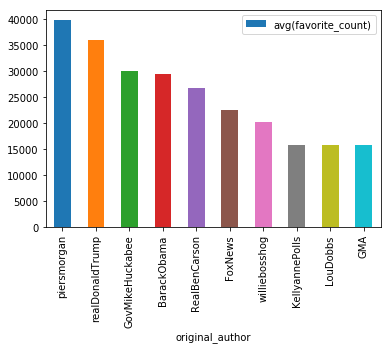

In [368]:
author_name = input("Enter 'h' for Hillary Clinton and 't' for Donald Trump: ")
opperation = input("Enter 's' for sum and 'a' average: ")

if opperation == 's':
    if author_name == 'h':
        authors_plot = retweets_hillary_likes_sum.toPandas()

    elif author_name == 't':
        authors_plot = retweets_trump_likes_sum.toPandas()
    authors_plot.plot('original_author', 'sum(favorite_count)', kind = 'bar')

elif opperation == 'a':
    if author_name == 'h':
        authors_plot = retweets_hillary_likes_avg.toPandas()

    elif author_name == 't':
        authors_plot = retweets_trump_likes_avg.toPandas()
    authors_plot.plot('original_author', 'avg(favorite_count)', kind = 'bar')

plt.show()

### Finding the retweets with the most retweets

#### For Hillary

#### Retweets sum

In [370]:
# Hillary
retweets_hillary_retweets_sum = retweets.filter("handle = 'HillaryClinton'").select('original_author', 'retweet_count').groupBy('original_author').sum('retweet_count').sort('sum(retweet_count)', ascending=False).limit(10)
retweets_hillary_retweets_sum.show(10,False)

+---------------+------------------+
|original_author|sum(retweet_count)|
+---------------+------------------+
|POTUS          |158018            |
|TheBriefing2016|117414            |
|timkaine       |115794            |
|BernieSanders  |62181             |
|elizabethforma |57769             |
|JoeBiden       |57051             |
|HFA            |56049             |
|SenSanders     |52673             |
|repjohnlewis   |40025             |
|billclinton    |29700             |
+---------------+------------------+



##### Retweets average

In [372]:
retweets_hillary_retweets_avg = retweets.filter("handle = 'HillaryClinton'").select('original_author', 'retweet_count').groupBy('original_author').avg('retweet_count').sort('avg(retweet_count)', ascending=False).limit(10)
retweets_hillary_retweets_avg.show(10,False)

+---------------+------------------+
|original_author|avg(retweet_count)|
+---------------+------------------+
|POTUS          |39504.5           |
|funnyordie     |28387.0           |
|SenSanders     |26336.5           |
|TammyforIL     |24200.0           |
|MittRomney     |13217.5           |
|CNBCnow        |10813.0           |
|ElizabethBanks |10352.0           |
|repjohnlewis   |10006.25          |
|jtimberlake    |9979.0            |
|elizabethforma |9628.166666666666 |
+---------------+------------------+



#### For Trump

##### Retweets sum

In [142]:
# Trump
retweets_trump_retweets = retweets.filter("handle = 'realDonaldTrump'").select('original_author', 'retweet_count').groupBy('original_author').sum('retweet_count').sort('sum(retweet_count)', ascending=False).limit(10)
retweets_trump_retweets.show(10,False)

+---------------+-------------+
|original_author|retweet_count|
+---------------+-------------+
|BarackObama    |27727        |
|RealBenCarson  |21602        |
|GovMikeHuckabee|16814        |
|piersmorgan    |16805        |
|DanScavino     |13146        |
|RealBenCarson  |11725        |
|benshapiro     |10426        |
|realDonaldTrump|10277        |
|EricTrump      |10182        |
|LouDobbs       |9401         |
+---------------+-------------+



##### Retweets average

In [373]:
retweets_trump_retweets = retweets.filter("handle = 'realDonaldTrump'").select('original_author', 'retweet_count').groupBy('original_author').avg('retweet_count').sort('avg(retweet_count)', ascending=False).limit(10)
retweets_trump_retweets.show(10,False)

+---------------+------------------+
|original_author|avg(retweet_count)|
+---------------+------------------+
|BarackObama    |27727.0           |
|GovMikeHuckabee|16814.0           |
|piersmorgan    |16805.0           |
|RealBenCarson  |14072.333333333334|
|benshapiro     |10426.0           |
|realDonaldTrump|10277.0           |
|williebosshog  |9156.0            |
|FoxNews        |9029.0            |
|NRA            |7668.0            |
|GMA            |6947.0            |
+---------------+------------------+



#### Visualizing the results

Enter 'h' for Hillary Clinton and 't' for Donald Trump: h
Enter 's' for sum and 'a' average: s


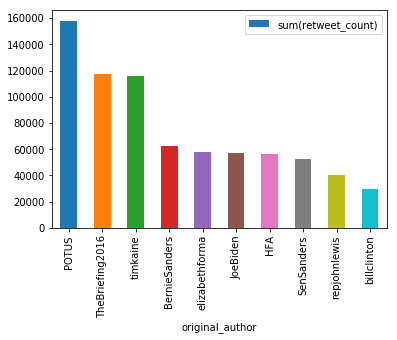

In [374]:
author_name = input("Enter 'h' for Hillary Clinton and 't' for Donald Trump: ")
opperation = input("Enter 's' for sum and 'a' average: ")

if opperation == 's':
    if author_name == 'h':
        authors_plot = retweets_hillary_retweets_sum.toPandas()

    elif author_name == 't':
        authors_plot = retweets_trump_retweets_sum.toPandas()
    authors_plot.plot('original_author', 'sum(retweet_count)', kind = 'bar')

elif opperation == 'a':
    if author_name == 'h':
        authors_plot = retweets_hillary_retweets_avg.toPandas()

    elif author_name == 't':
        authors_plot = retweets_trump_retweets_avg.toPandas()
    authors_plot.plot('original_author', 'avg(retweet_count)', kind = 'bar')

plt.show()

### Checking if there are any mutual authors between the two candidates

In [369]:
# Finding the overlap of authors between the two candidates
retweets_trump_counts.join(retweets_hillary_counts, 'original_author').show(10)

+---------------+-----+-----+
|original_author|count|count|
+---------------+-----+-----+
|            GMA|    1|    1|
|    Morning_Joe|    1|    1|
+---------------+-----+-----+



## Finding the number of likes and retweets in each month

### Number of likes in each month

#### For Hillary

In [376]:
likes_month_hillary = clean_text.filter("handle = 'HillaryClinton'").select('month', 'favorite_count').groupBy('month').sum('favorite_count').sort('month')
likes_plot_hillary = likes_month_hillary.toPandas()
likes_plot_hillary

,month,sum(favorite_count)
0,4,548021
1,5,1118879
2,6,4175061
3,7,6444028
4,8,3450891
5,9,5501525


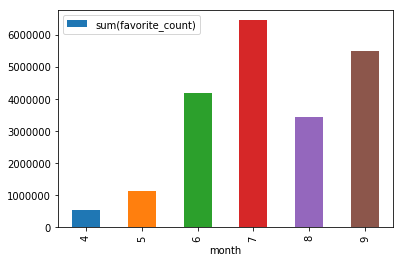

In [377]:
likes_plot_hillary.plot('month', 'sum(favorite_count)', kind = 'bar')
plt.show()

#### For Trump

In [378]:
likes_month_trump = clean_text.filter("handle = 'realDonaldTrump'").select('month', 'favorite_count').groupBy('month').sum('favorite_count').sort('month')
likes_plot_trump = likes_month_trump.toPandas()
likes_plot_trump

,month,sum(favorite_count)
0,1,2486866
1,2,4127009
2,3,6760867
3,4,3763150
4,5,5423054
5,6,5979544
6,7,10349780
7,8,6867500
8,9,6446583


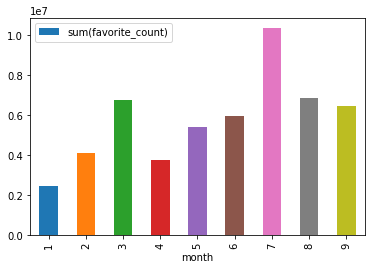

In [379]:
likes_plot_trump.plot('month', 'sum(favorite_count)', kind = 'bar')
plt.show()

### Both candidates on the same plot for comparison

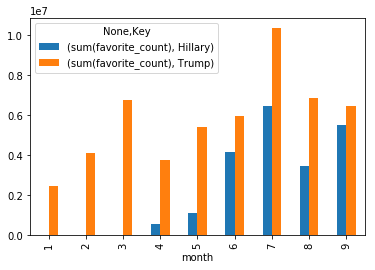

In [383]:
likes_plot_hillary['Key'] = 'Hillary'
likes_plot_trump['Key'] = 'Trump'

DF = pd.concat([likes_plot_hillary,likes_plot_trump],keys=['Hillary','Trump'])

DFGroup = DF.groupby(['month','Key'])

DFGPlot = DFGroup.sum().unstack('Key').plot(kind='bar')

### Number of retweets in each month

#### For Hillary

In [385]:
retweets_month_hillary = clean_text.filter("handle = 'HillaryClinton'").select('month', 'retweet_count').groupBy('month').sum('retweet_count').sort('month')
retweets_plot_hillary = retweets_month_hillary.toPandas()
retweets_plot_hillary

,month,sum(retweet_count)
0,4,253749
1,5,550875
2,6,1966533
3,7,2547387
4,8,1424156
5,9,2694383


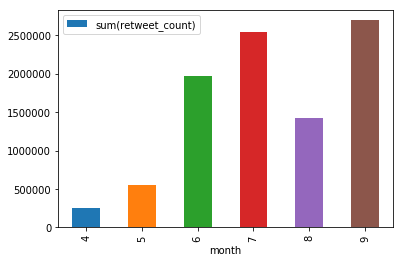

In [386]:
retweets_plot_hillary.plot('month', 'sum(retweet_count)', kind = 'bar')
plt.show()

#### For Trump

In [389]:
retweets_month_trump = clean_text.filter("handle = 'realDonaldTrump'").select('month', 'retweet_count').groupBy('month').sum('retweet_count').sort('month')
retweets_plot_trump = retweets_month_trump.toPandas()
retweets_plot_trump

,month,sum(retweet_count)
0,1,899136
1,2,1505018
2,3,2368828
3,4,1300890
4,5,1826824
5,6,2147878
6,7,3450001
7,8,2377310
8,9,2292289


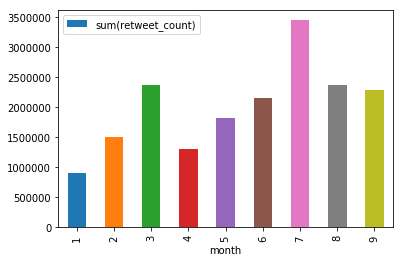

In [390]:
retweets_plot_trump.plot('month', 'sum(retweet_count)', kind = 'bar')
plt.show()

### Both candidates on the same plot for comparison

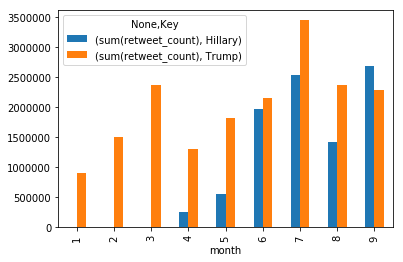

In [393]:
retweets_plot_hillary['Key'] = 'Hillary'
retweets_plot_trump['Key'] = 'Trump'

DF = pd.concat([retweets_plot_hillary,retweets_plot_trump],keys=['Hillary','Trump'])

DFGroup = DF.groupby(['month','Key'])

DFGPlot = DFGroup.sum().unstack('Key').plot(kind='bar')

# Plotting the n-grams
For each of the following sections, the user will choose the candidate and the number of ngrams

## Ngrams vs Counts

Enter 'h' for Hillary Clinton and 't' for Donald Trump: h
Enter the number of grams: 2


,n_grams,count
0,donald trump,311
1,hillary clinton,90
2,donald trump's,51
3,make sure,45
4,united states,41
5,trump says,31
6,gun violence,28
7,stronger together,26
8,last night,24
9,years ago,24


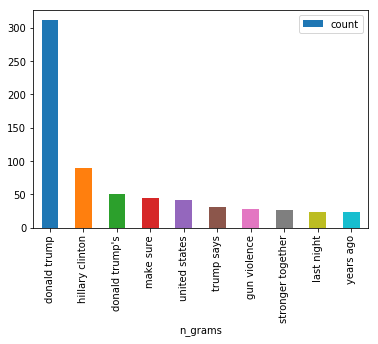

In [395]:
candidate_name = input("Enter 'h' for Hillary Clinton and 't' for Donald Trump: ")
n_grams = input("Enter the number of grams: ")

ngram = NGram(n=int(n_grams), inputCol="words_clean", outputCol="ngrams")

df_with_ngrams = ngram.transform(clean_text)
#ngramDataFrame.select("ngrams").show(truncate=False)

if candidate_name == 'h':
    ngrams_df = df_with_ngrams.filter("handle = 'HillaryClinton'").withColumn('n_grams', explode('ngrams')).groupBy('n_grams').count().sort('count', ascending=False)

elif candidate_name == 't':
    ngrams_df = df_with_ngrams.filter("handle = 'realDonaldTrump'").withColumn('n_grams', explode('ngrams')).groupBy('n_grams').count().sort('count', ascending=False)

ngrams_df_plot_counts = ngrams_df.limit(10).toPandas()
display(ngrams_df_plot_counts)
ngrams_df_plot_counts.plot('n_grams', 'count', kind = 'bar')
plt.show()

## Ngrams vs Likes

Enter 'h' for Hillary Clinton and 't' for Donald Trump: t
Enter the number of grams: 3


,n_grams,sum(favorite_count)
0,crooked hillary clinton,1857328
1,make america great,1563989
2,make america safe,530636
3,goofy elizabeth warren,423949
4,lyin' ted cruz,326559
5,america safe great,314195
6,upand 33000 emails,294162
7,33000 emails deleted,294162
8,think upand 33000,294162
9,staff 823 people,294162


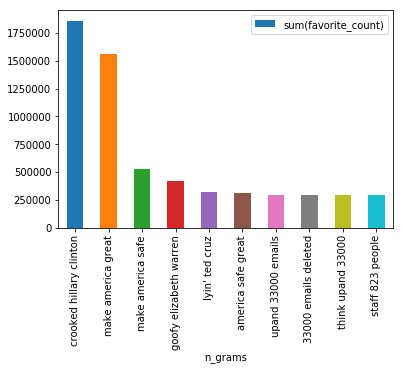

In [396]:
candidate_name = input("Enter 'h' for Hillary Clinton and 't' for Donald Trump: ")
n_grams = input("Enter the number of grams: ")

ngram = NGram(n=int(n_grams), inputCol="words_clean", outputCol="ngrams")

df_with_ngrams = ngram.transform(clean_text)
#ngramDataFrame.select("ngrams").show(truncate=False)

if candidate_name == 'h':
    ngrams_df = df_with_ngrams.filter("handle = 'HillaryClinton'").withColumn('n_grams', explode('ngrams')).groupBy('n_grams').sum('favorite_count').sort('sum(favorite_count)', ascending=False)

elif candidate_name == 't':
    ngrams_df = df_with_ngrams.filter("handle = 'realDonaldTrump'").withColumn('n_grams', explode('ngrams')).groupBy('n_grams').sum('favorite_count').sort('sum(favorite_count)', ascending=False)

ngrams_df_plot_counts = ngrams_df.limit(10).toPandas()
display(ngrams_df_plot_counts)
ngrams_df_plot_counts.plot('n_grams', 'sum(favorite_count)', kind = 'bar')
plt.show()

## Ngrams vs Retweets

Enter 'h' for Hillary Clinton and 't' for Donald Trump: h
Enter the number of grams: 4


,n_grams,sum(retweet_count)
0,said donald trump said,91670
1,never said donald trump,91670
2,trump called miss piggy,80576
3,proud standing hillary tonight,80169
4,quits hillary next get,63628
5,next get twitter handle,63628
6,speech tested ready never,63628
7,tested ready never quits,63628
8,great speech tested ready,63628
9,never quits hillary next,63628


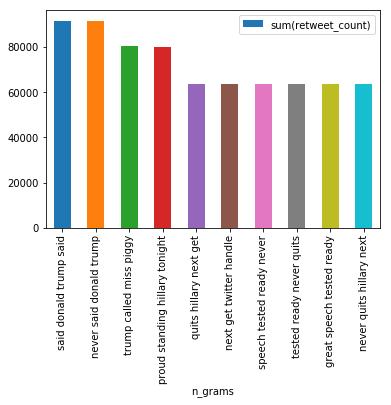

In [397]:
candidate_name = input("Enter 'h' for Hillary Clinton and 't' for Donald Trump: ")
n_grams = input("Enter the number of grams: ")

ngram = NGram(n=int(n_grams), inputCol="words_clean", outputCol="ngrams")

df_with_ngrams = ngram.transform(clean_text)
#ngramDataFrame.select("ngrams").show(truncate=False)

if candidate_name == 'h':
    ngrams_df = df_with_ngrams.filter("handle = 'HillaryClinton'").withColumn('n_grams', explode('ngrams')).groupBy('n_grams').sum('retweet_count').sort('sum(retweet_count)', ascending=False)

elif candidate_name == 't':
    ngrams_df = df_with_ngrams.filter("handle = 'realDonaldTrump'").withColumn('n_grams', explode('ngrams')).groupBy('n_grams').sum('retweet_count').sort('sum(retweet_count)', ascending=False)

ngrams_df_plot_counts = ngrams_df.limit(10).toPandas()
display(ngrams_df_plot_counts)
ngrams_df_plot_counts.plot('n_grams', 'sum(retweet_count)', kind = 'bar')
plt.show()

# Sentimental Analysis

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /u4/mdib/nltk_data...


True

In [398]:
# Function for finding the sentiment score
def tweet_score(x):
    analyzer = SentimentIntensityAnalyzer()
    score = 0
    for i in x:
        temp = analyzer.polarity_scores(i)
        score += temp['compound']
        
    return score

In [399]:
# Function for assigning the sentiment
def tweet_sentiment(x):
    
    if x > 0:
        sentiment = 'Positive'
    elif x == 0:
        sentiment = 'Neutral'
    elif x < 0:
        sentiment = 'Negative'
        
    return sentiment

In [ ]:
score_udf = udf(tweet_score, FloatType())
sentiment_udf = udf(tweet_sentiment, StringType())

sentiment = clean_text.withColumn("tweet_score", score_udf("words_stem")).withColumn("tweet_sentiment", sentiment_udf("tweet_score"))


In [ ]:
sentiment.select('handle', 'text', 'tweet_score', 'tweet_sentiment').show(15, False)

## The sentiments of Hillary's tweets

In [407]:
sentiment_hillary = sentiment.filter("handle = 'HillaryClinton'").groupBy('tweet_sentiment').count()

In [408]:
sentiment_hillary.show()

+---------------+-----+
|tweet_sentiment|count|
+---------------+-----+
|       Positive| 1349|
|        Neutral|  991|
|       Negative|  777|
+---------------+-----+



## The sentiments of Trump's tweets

In [410]:
sentiment_trump = sentiment.filter("handle = 'realDonaldTrump'").groupBy('tweet_sentiment').count()

In [411]:
sentiment_trump.show()

+---------------+-----+
|tweet_sentiment|count|
+---------------+-----+
|       Positive| 1778|
|        Neutral|  621|
|       Negative|  732|
+---------------+-----+

